Per il coach che correggera' questo progetto:

1. Il progetto viene mostrato seguendo la pipeline standard, dall'import alla discussione finale. Oltre alle richieste scritte nelle linee guida, ho aggiunto qualche dettaglio extra come lo studio delle correlazioni, lo studio degli outliers ed un tentativo semplice (i.e. senza usare PyTorch) di Neural Network, sebbene ci fossero tutti i presupposti per cui non sarebbe stato utile. Essendo il dataset piccolo, trainare un NN richiede pochi secondi e quindi non e' un grande spreco di tempo.

2. Ho impostato il notebook in modo estremamente didattico, con spiegazioni dettagliate di ogni passaggio (probabilmente spiegazioni ridondanti, ma meglio abbondare in questo contesto).

3. L'approccio metodologico confronta varie metriche di tutti i modelli di regressione, dove gli iperparametri (ove presenti) sono selezionati tramite 5-fold cross-validation.

4. Sono consapevole che le funzioni scritte manualmente da me potrebbero essere rese molto piu' robuste (controlli sugli input, eccetera). Per tenere il progetto autoconsistente ma senza esagerare, ho usato definizioni funzionali al contesto.

5. Il notebook è stato sviluppato in modo da poter essere rieseguito integralmente dall’inizio senza errori o dipendenze esterne.

6. **Non ho copiato nessun codice**, usando solo la reference ufficiale di Scikit-learn.


***Chiedo al coach una valutazione il piu' possibile severa***. Se fosse possibile, gradirei sapere la votazione, per poter tenere traccia delle mie skills in futuro.

# 0) Libraries and Imports

In [ ]:
############# Standard Imports #############

import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

############# Useful Classes and Methods #############

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, Normalizer, PolynomialFeatures

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, KFold

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


# 1) Dataset Exploration and Preprocessing

In questa sezione verra' esplorato il dataset.

Significato delle variabili:
- **Price**: il prezzo, il target da prevedere
- **Area**: superficie dell’immobile
- **Bedrooms**: numero di camere da letto
- **Bathrooms**: numero di bagni
- **Stories**: numero di piani
- **Mainroad**: vale 1 se l’immobile affaccia su una strada principale, 0 altrimenti
- **guestroom**: vale 1 se l’immobile ha una stanza degli ospiti, 0 altrimenti
- **basement**: vale 1 se l’immobile ha un seminterrato, 0 altrimenti
- **hotwaterheating**: vale 1 se l’immobile ha una caldaia, 0 altrimenti
- **airconditioning**: vale 1 se l’immobile ha l’aria condizionata, 0 altrimenti
- **parking**: numero di parcheggi
- **prefarea**: vale 1 se l’immobile è in una zona prestigiosa, 0 altrimenti
- **Furnishingstatus**: vale 0 se l’immobile non è arredato, 1 se è parzialmente arredato, 2 se è completamente arredato


In [ ]:
url = "https://proai-datasets.s3.eu-west-3.amazonaws.com/housing.csv"
df = pd.read_csv(url)

total_rows = df.shape[0]
total_columns = df.shape[1]

target = 'price'
min_target = np.min(df['price'])
max_target = np.max(df['price'])
mean_target = np.mean(df['price']).item()

print(f"This dataset has {total_rows} total rows and {total_columns} total columns, of which 1 is the target (column '{target}').\n\n")
df.head()

This dataset has 545 total rows and 13 total columns, of which 1 is the target (column 'price').




,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,1
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,1
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,2
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,1
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,1


Vediamo il tipo di ogni colonna e quanti valori sono mancanti:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   price             545 non-null    int64
 1   area              545 non-null    int64
 2   bedrooms          545 non-null    int64
 3   bathrooms         545 non-null    int64
 4   stories           545 non-null    int64
 5   mainroad          545 non-null    int64
 6   guestroom         545 non-null    int64
 7   basement          545 non-null    int64
 8   hotwaterheating   545 non-null    int64
 9   airconditioning   545 non-null    int64
 10  parking           545 non-null    int64
 11  prefarea          545 non-null    int64
 12  furnishingstatus  545 non-null    int64
dtypes: int64(13)
memory usage: 55.5 KB


Tutti i dati sono dalvati come interi e non ci sono valori mancanti. Confermiamolo:

In [ ]:
df.isnull().sum().tolist()

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Facciamo un'ispezione della correlazione fra i dati. L'utilizzo di variabili molto correlate fra loro peggiora l'analisi con qualsiasi modello. Inoltre se ci sono variabili poco correlate con il target, si potrebbero eliminare. Dalla matrice di correlazione non si evince una particolare correlazione fra le features ed il target (la correlazione massima, come era immaginabile, si ha con 'area'). La variabile meno correlata e' 'hotwaterheating', che si potrebbe scartare. La correlazione tra le features non e' alta, cioe' (da questo punto di vista) tutte le variabili sono importanti:

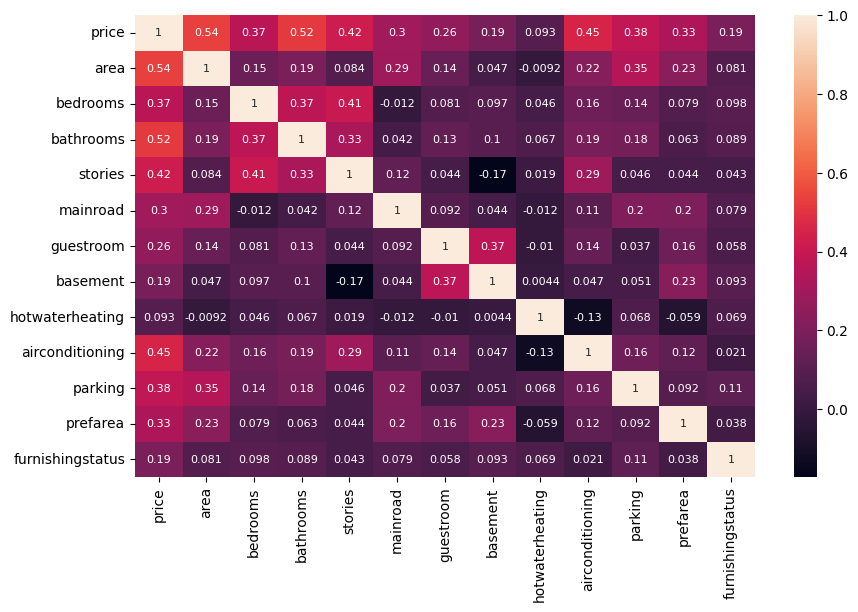

In [ ]:
df.corr()
plt.figure(figsize = (10,6))
sns.heatmap(df.corr(),
            annot = True,
            annot_kws = {'size': 8})
plt.show()
plt.close()

Posso automatizzare il processo di selezione delle features in questo modo, se necessario:

In [ ]:
corr = df.drop([target], axis = 1).corrwith(df[target])
corr = np.abs(corr).sort_values(ascending = True)
min_corr_features = list(corr.index)
print(min_corr_features)

['hotwaterheating', 'basement', 'furnishingstatus', 'guestroom', 'mainroad', 'prefarea', 'bedrooms', 'parking', 'stories', 'airconditioning', 'bathrooms', 'area']


Prima di tutto dividiamo il dataset in variabile indipendente ($y$, colonna 'price') e nei dati che useremo come variabili dipendenti ($X$). Tra le features che utilizzeremo, scartiamo 'hotwaterheating' (*A posteriori*, ho visto che le metriche migliorano di un poco eliminando 'hotwaterheating'). La colonna 'price', essendo il target, non subira' nessuna normalizzazione. Per sicurezza controlliamo anche se ci sono outliers:

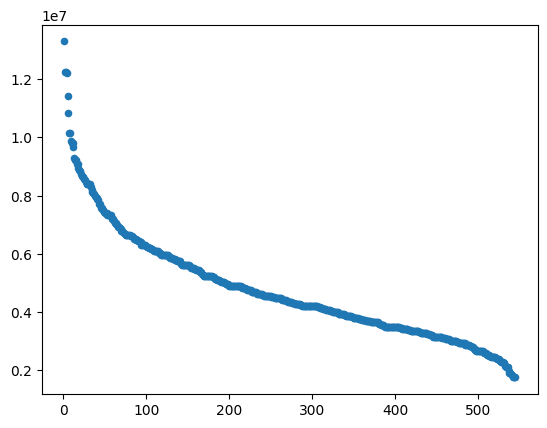

In [ ]:
plt.scatter(range(1, df[[target]].shape[0]+1),df[[target]], s = 20)
plt.show()
plt.close()

Visivamente, ci sono outliers (pochissimi dati in un ordine di grandezza superiore). Inoltre notiamo che i valori sono stati ordinati in ordine decrescente: sara' necessario uno shuffle per essere sicuri di non avere pattern troppo definiti. Controlliamo meglio la presenza di outliers con un box plot che conferma la precedente affermazione:

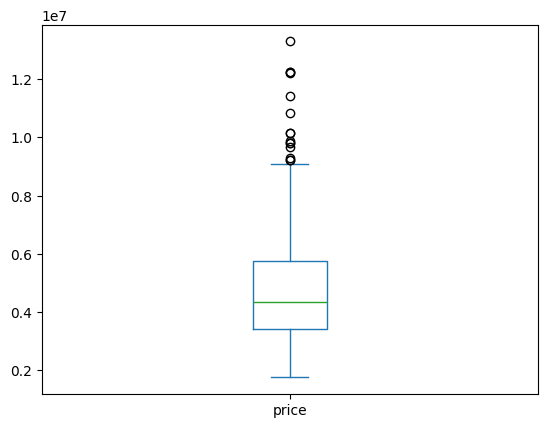

In [ ]:
df[[target]].plot(kind='box')
plt.show()
plt.close()

Scartiamo gli outliers. Ci sono due modi:
- creare un train-test split standard e rimuovere gli outliers **solo** dal train set;
- creare un train-test split manuale dove scaricare tutti gli outliers direttamente nel test set. Questo approccio crea un test set sfidante e potrebbe andare bene per dati buoni/poco rumorosi.

*A posteriori*, avendo visto che il modello di regressione non produce buoni risultati sul test set, e' piu' proficuo seguire il primo approccio.

In [ ]:
y = df[[target]] # it is a DataFrame object
X = df.drop(columns = [target,'hotwaterheating'] , axis = 1) # it is a DataFrame object

Ci salviamo le variabili numeriche e quelle categoriche (nominali ed ordinabili) per le analisi successive:

In [ ]:
numerical_variables = ["area", "bedrooms", "bathrooms", "stories", "parking"] # should undergo under standardization/normalization
ordinal_variables = ["furnishingstatus"] # should undergo ordinal encoding
categorical_variables = ["mainroad", "guestroom", "basement", "hotwaterheating", "airconditioning", "prefarea"] # should undergo one-hot encoding

len(numerical_variables + ordinal_variables + categorical_variables) + 1 == df.shape[1]

True

Nonostante io abbia diviso le colonne per chiarezza, non e' neccessaria alcuna azione ulteriore di encoding sulle variabili categoriche. Infatti sono categoriche ma sono gia' state convertite in un formato numerico accettabile. Le colonne numeriche invece necessitano uno scaling. Per farlo, e' necessario prima splittare in train-test. Avendo circa 500 esempi (che non sono poi molti), usero' una test size del 30%:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                    shuffle = True, # necessary because the dataset is ordered
                                                    random_state = 0) # DataFrame objects

Prima di scalare i dati, rimuoviamo gli outliers:

In [ ]:
q1 = np.percentile(y, 25)
q3 = np.percentile(y, 75)
iqr = q3 - q1
upper_whisker = q3 + 1.5 * iqr # Upper whisker definition

outlier_mask = (y_train < upper_whisker).values

test_size_before = y_train.shape[0]

X_train = X_train.loc[outlier_mask]
y_train = y_train.loc[outlier_mask]

test_size_after = y_train.shape[0]

print(f"Sono stati eliminati {test_size_before-test_size_after} campioni dal training set.")

Sono stati eliminati 9 campioni dal training set.


In [ ]:
ss = StandardScaler()

X_train[numerical_variables] = ss.fit_transform(X_train[numerical_variables])
X_test[numerical_variables] = ss.transform(X_test[numerical_variables])

X_train.head() # DataFrame object

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,airconditioning,parking,prefarea,furnishingstatus
454,-0.265050,0.094706,-0.563316,0.218650,1,0,0,1,-0.806549,0,0
392,-0.525605,0.094706,-0.563316,0.218650,1,0,0,0,-0.806549,0,2
231,-0.357011,0.094706,-0.563316,-0.926953,1,0,0,0,-0.806549,1,2
271,-1.590816,2.913150,-0.563316,0.218650,0,0,1,0,-0.806549,0,2
250,-0.770834,0.094706,-0.563316,1.364253,1,0,0,0,-0.806549,0,2


# 2) Regression models

Prima di tutto definiamo una funzione comoda per fittare e valutare un modello. Se `verbose` e' `True`, mostra una tabella riassuntiva. Inoltre, calcola quanti parametri ('non nulli') ha davvero il modello guardando l'importanza relativa dei parametri del modello: se un parametro pesa (relativamente) meno della `threshold`, viene considerato come assente. Ritorna tutto quello che servira' nelle analisi successive:

In [ ]:
def fit_evaluate(model, X_train, X_test, y_train, y_test, verbose = False, threshold = 0.05):

  """
  Input: a model of sklearn that support .fit() and .predict(); four tensors that can be Numpy arrays or Pandas DataFrames.
  verbose: if True, the function prints a summary of the standard metrics of a regression problem, both for the train and validation/test set.
  threshold: percentage under which features are considered irrelevant to the model.
  """

  if isinstance(X_train, pd.DataFrame): X_train = X_train.values
  if isinstance(X_test, pd.DataFrame): X_test = X_test.values
  if isinstance(y_train, pd.DataFrame): y_train = y_train.values
  if isinstance(y_test, pd.DataFrame): y_test = y_test.values

  model.fit(X_train, y_train)
  yhat_train = model.predict(X_train) # predictions for the training set
  yhat_test = model.predict(X_test)

  try:
    all_coefs = np.abs(model.coef_.squeeze())
    relative_importance = all_coefs/np.max(all_coefs)
    magnitude = np.sum((relative_importance > threshold).astype(int)).item()
  except:
    magnitude = np.nan

  metrics = ["Mean Squared (MSE)", "Root Mean Squared (RMSE)", "Mean Absolute (MAE)", "R2 Score", "Min", "Mean", "Max"]
  split = ["Train", "Validation/Test"]

  # train metrics

  mse_train = mean_squared_error(y_train, yhat_train)
  rmse_train = np.sqrt(mse_train)
  mae_train = mean_absolute_error(y_train, yhat_train)
  r2_train = r2_score(y_train, yhat_train)
  min_train = np.min(y_train)
  max_train = np.max(y_train)
  mean_train = np.mean(y_train)

  # test metrics

  mse_test = mean_squared_error(y_test, yhat_test)
  rmse_test = np.sqrt(mse_test)
  mae_test = mean_absolute_error(y_test, yhat_test)
  r2_test = r2_score(y_test, yhat_test)
  min_test = np.min(y_test)
  max_test = np.max(y_test)
  mean_test = np.mean(y_test)


  metrics_df = pd.DataFrame([[mse_train, rmse_train, mae_train, r2_train, min_train, mean_train, max_train],
                            [mse_test, rmse_test, mae_test, r2_test, min_test, mean_test, max_test]], columns = metrics, index = split)
  if verbose: display(metrics_df)

  predictions = [yhat_train, yhat_test]
  metrics = [mse_train, r2_train, mse_test, r2_test]

  return model, predictions, metrics, magnitude, metrics_df

## 2a) Linear regression (without regularization)

Prima di addentrarci in modelli complessi, studiamo un modello baseline di regressione lineare semplice.

Il modello semplice si comporta discretamente sul set di training ed un po' meglio sul test set. Tuttavia, un $R^2$ poco maggiore di $0.7$ non e' sicuramente accettabile per fare il deploy del modello:

In [ ]:
lr = LinearRegression()
print("\n")
trained_lr, predictions_lr, metrics_lr, magnitude_lr, df_lr = fit_evaluate(lr, X_train, X_test, y_train, y_test, verbose = True)

print(f"\n\nThe model contains {magnitude_lr} relevant features out of {trained_lr.coef_.shape[1]} (features and bias).")


,Mean Squared (MSE),Root Mean Squared (RMSE),Mean Absolute (MAE),R2 Score,Min,Mean,Max
Train,9.203522e+11,959349.890954,724074.165698,0.647545,1750000,4.620074e+06,9100000
Validation/Test,9.445782e+11,971894.131438,718788.607520,0.727691,1750000,4.763500e+06,12250000




The model contains 11 relevant features out of 11 (features and bias).


Anche se non si vedono i segni classici di overfitting in questo caso, ha comunque senso provare a regolarizzare: per esempio, potrebbe aver senso fare feature selection. Il metodo utilizzato sopra per valutare quanti features sono rilevanti e' molto manuale, e potrebbe non essere sempre efficace.

## 2b) Polynomial regression

Proviamo una regressione polinomiale per qualche grado del polinomio. Il risultato e' che da subito abbiamo forte overfitting, segnale del fatto che i dati sono molto semplici ed un polinomio si adatta subito alla struttura dei dati senza imparare nulla sulla loro reale distribuzione. Infatti, prendendo come metrica l'R2, c'e' un notevole peggioramento sul test set rispetto al training set:

In [ ]:
for d in [2,3,4,5]:

  print(f"\t\t\t\t\t\t\t\t\t\t\t\t\tUsing a polynomial of degree d = {d}.\n")

  poly = PolynomialFeatures(degree = d, include_bias = True)
  X_train_poly = poly.fit_transform(X_train)
  X_test_poly = poly.transform(X_test)

  ss = StandardScaler()
  X_train_poly = ss.fit_transform(X_train_poly)
  X_test_poly = ss.transform(X_test_poly)

  lr = LinearRegression()
  _, _, _, _, _, = fit_evaluate(lr, X_train_poly, X_test_poly, y_train, y_test, verbose = True)

  print("\n","-"*160,"\n")


													Using a polynomial of degree d = 2.



,Mean Squared (MSE),Root Mean Squared (RMSE),Mean Absolute (MAE),R2 Score,Min,Mean,Max
Train,6.588621e+11,8.117032e+05,613441.665265,0.747685,1750000,4.620074e+06,9100000
Validation/Test,1.184905e+12,1.088534e+06,829420.963759,0.658408,1750000,4.763500e+06,12250000



 ---------------------------------------------------------------------------------------------------------------------------------------------------------------- 

													Using a polynomial of degree d = 3.



,Mean Squared (MSE),Root Mean Squared (RMSE),Mean Absolute (MAE),R2 Score,Min,Mean,Max
Train,1.420196e+11,3.768549e+05,2.554144e+05,0.945613,1750000,4.620074e+06,9100000
Validation/Test,4.579190e+14,2.139904e+07,8.388588e+06,-131.011758,1750000,4.763500e+06,12250000



 ---------------------------------------------------------------------------------------------------------------------------------------------------------------- 

													Using a polynomial of degree d = 4.



,Mean Squared (MSE),Root Mean Squared (RMSE),Mean Absolute (MAE),R2 Score,Min,Mean,Max
Train,2.612151e+10,1.616215e+05,4.132997e+04,0.989997,1750000,4.620074e+06,9100000
Validation/Test,9.398361e+17,9.694515e+08,2.382433e+08,-270940.835185,1750000,4.763500e+06,12250000



 ---------------------------------------------------------------------------------------------------------------------------------------------------------------- 

													Using a polynomial of degree d = 5.



,Mean Squared (MSE),Root Mean Squared (RMSE),Mean Absolute (MAE),R2 Score,Min,Mean,Max
Train,1.525783e+10,1.235226e+05,2.110109e+04,9.941569e-01,1750000,4.620074e+06,9100000
Validation/Test,6.291888e+20,2.508364e+10,3.750414e+09,-1.813865e+08,1750000,4.763500e+06,12250000



 ---------------------------------------------------------------------------------------------------------------------------------------------------------------- 



## 2c) Cross-validation and regularization

In questa sezione proviamo a fare regolarizzazione. I modelli che useremo contengono degli iperparametri, ed e' quindi necessario fare cross-validation. Potrei usare `cross_val_score`, `cross_validate`ed anche `GridSearchCV`. Tuttavia permettono di entrare poco nei dettagli del modello.
Definiamo quindi un'apposita funzione per fare cross-validation, pensata per lavorare in collaborazione con la classe `KFold` di Scikit-learn:

In [ ]:
def my_crossval(method, model, X_train, y_train, numerical_variables, verbose = True): # 'method' can be an object KFold() or also LeaveOneOut()
                                                                                       # X_train and y_train must be Pandas DataFrames
  mse_train_cv = []
  r2_train_cv = []
  mse_test_cv = []
  r2_test_cv = []

  for train_indices, test_indices in method.split(X_train):

    X_train_cv, X_test_cv = X_train.iloc[train_indices].copy(), X_train.iloc[test_indices].copy()
    y_train_cv, y_test_cv = y_train.iloc[train_indices].copy(), y_train.iloc[test_indices].copy()

    ss = StandardScaler()
    X_train_cv[numerical_variables] = ss.fit_transform(X_train_cv[numerical_variables])
    X_test_cv[numerical_variables] = ss.transform(X_test_cv[numerical_variables])

    _, _, metrics_model, _, _ = fit_evaluate(model, X_train_cv, X_test_cv, y_train_cv, y_test_cv, verbose = False)

    mse_train = round(metrics_model[0], 4)
    r2_train = round(metrics_model[1], 4)
    mse_test = round(metrics_model[2], 4)
    r2_test = round(metrics_model[3], 4)

    mse_train_cv.append(mse_train)
    r2_train_cv.append(r2_train)
    mse_test_cv.append(mse_test)
    r2_test_cv.append(r2_test)

  if verbose:
#    print(f"MSEs train: {mse_train_cv}; MSE mean: {np.mean(mse_train_cv).item()}")
#    print(f"MSEs test: {mse_test_cv}; MSE mean: {np.mean(mse_test_cv).item()}")

    print(f"\nR2s train: {r2_train_cv}; R2 mean: {np.mean(r2_train_cv).item()}")
    print(f"R2s test: {r2_test_cv}; R2 mean: {np.mean(r2_test_cv).item()}")

  return mse_train_cv, r2_train_cv, mse_test_cv, r2_test_cv

# usage example with a linear regression model

kf = KFold(n_splits = 5, shuffle = True, random_state = 0)
model = LinearRegression()
mse_train_cv, r2_train_cv, mse_test_cv, r2_test_cv = my_crossval(kf, model, X_train, y_train, numerical_variables)


R2s train: [0.6498, 0.6643, 0.6617, 0.6252, 0.6472]; R2 mean: 0.64964
R2s test: [0.6256, 0.5619, 0.5604, 0.7322, 0.6369]; R2 mean: 0.6234


### Linear regression, with L2/Ridge regularization

In [ ]:
alphas = [0.1, 0.25, 0.5, 1, 2.5, 5, 10, 20]
kf = KFold(n_splits = 5, shuffle = True, random_state = 0)

print()
for alpha in alphas:

  print(f"\t\t\tUsing alpha = {alpha}")

  rr = Ridge(alpha = alpha)
  mse_train_cv, r2_train_cv, mse_test_cv, r2_test_cv = my_crossval(kf, rr, X_train, y_train, numerical_variables)

  print("\n","-"*160,"\n")


			Using alpha = 0.1

R2s train: [0.6498, 0.6643, 0.6617, 0.6252, 0.6472]; R2 mean: 0.64964
R2s test: [0.6256, 0.5619, 0.5605, 0.7323, 0.637]; R2 mean: 0.6234599999999999

 ---------------------------------------------------------------------------------------------------------------------------------------------------------------- 

			Using alpha = 0.25

R2s train: [0.6498, 0.6643, 0.6617, 0.6252, 0.6472]; R2 mean: 0.64964
R2s test: [0.6256, 0.562, 0.5607, 0.7323, 0.6371]; R2 mean: 0.62354

 ---------------------------------------------------------------------------------------------------------------------------------------------------------------- 

			Using alpha = 0.5

R2s train: [0.6498, 0.6643, 0.6617, 0.6252, 0.6472]; R2 mean: 0.64964
R2s test: [0.6256, 0.562, 0.5609, 0.7323, 0.6373]; R2 mean: 0.6236200000000001

 ---------------------------------------------------------------------------------------------------------------------------------------------------------------- 

	

Dal print subito sopra, vediamo che tutti i valori di alpha producono praticamente lo stesso risultato. Il migliore, in ogni caso, si ha con $\alpha = 5$. Vediamo il risultato ri-allenando questo modello:

In [ ]:
alpha_rr = 5
rr = Ridge(alpha = alpha_rr)

trained_rr, predictions_rr, metrics_rr, magnitude_rr, df_rr = fit_evaluate(rr, X_train, X_test, y_train, y_test, verbose = True)

print(f"The model contains {magnitude_rr} relevant features out of {trained_rr.coef_.shape[0]} total.")

,Mean Squared (MSE),Root Mean Squared (RMSE),Mean Absolute (MAE),R2 Score,Min,Mean,Max
Train,9.214070e+11,959899.472837,722191.557790,0.647141,1750000,4.620074e+06,9100000
Validation/Test,9.428244e+11,970991.465596,718178.624767,0.728197,1750000,4.763500e+06,12250000


The model contains 11 relevant features out of 11 total.


Il risultato e' praticamente analogo al caso senza regolarizzazione.

### Linear regression, with L1/Lasso regularization

In [ ]:
alphas = [0.1, 0.25, 0.5, 1, 2.5, 5, 10, 20]
kf = KFold(n_splits = 5, shuffle = True, random_state = 0)

print()
for alpha in alphas:

  print(f"\t\t\tUsing alpha = {alpha}")

  lasso_r = Lasso(alpha = alpha)
  mse_train_cv, r2_train_cv, mse_test_cv, r2_test_cv = my_crossval(kf, lasso_r, X_train, y_train, numerical_variables)

  print("\n","-"*160,"\n")


			Using alpha = 0.1

R2s train: [0.6498, 0.6643, 0.6617, 0.6252, 0.6472]; R2 mean: 0.64964
R2s test: [0.6256, 0.5619, 0.5604, 0.7322, 0.6369]; R2 mean: 0.6234

 ---------------------------------------------------------------------------------------------------------------------------------------------------------------- 

			Using alpha = 0.25

R2s train: [0.6498, 0.6643, 0.6617, 0.6252, 0.6472]; R2 mean: 0.64964
R2s test: [0.6256, 0.5619, 0.5604, 0.7322, 0.6369]; R2 mean: 0.6234

 ---------------------------------------------------------------------------------------------------------------------------------------------------------------- 

			Using alpha = 0.5

R2s train: [0.6498, 0.6643, 0.6617, 0.6252, 0.6472]; R2 mean: 0.64964
R2s test: [0.6256, 0.5619, 0.5604, 0.7322, 0.6369]; R2 mean: 0.6234

 ---------------------------------------------------------------------------------------------------------------------------------------------------------------- 

			Using alpha = 1

R2s

Anche in questo caso i risultati sono praticamente invariati:

In [ ]:
alpha_lasso_r = 5
lasso_r = Lasso(alpha = alpha_lasso_r)

trained_lasso_r, predictions_lasso_r, metrics_lasso_r, magnitude_lasso_r, df_lasso_r = fit_evaluate(lasso_r, X_train, X_test,
                                                                                                    y_train, y_test, verbose = True)

print(f"The model contains {magnitude_lasso_r} relevant features out of {trained_lasso_r.coef_.shape[0]} total.")

,Mean Squared (MSE),Root Mean Squared (RMSE),Mean Absolute (MAE),R2 Score,Min,Mean,Max
Train,9.203522e+11,959349.891200,724072.614147,0.647545,1750000,4.620074e+06,9100000
Validation/Test,9.445758e+11,971892.885821,718786.820433,0.727692,1750000,4.763500e+06,12250000


The model contains 11 relevant features out of 11 total.


### Linear regression, with ElasticNet regularization

For ElasticNet we have two parameter to choose: `alpha` and `l1_ratio`. For this reason we should define a grid search function:

In [ ]:
def grid_search_ElasticNet(method, params):

  """
  method is KFold() or LeaveOneOut()
  params is a dict with two entries: the first contains alphas and the second l1_ratios
  """
  print()
  for alpha in params["alphas"]:
    for l1_ratio in params["l1_ratios"]:

      print(f"\t\t\tUsing (alpha = {alpha}, l1_ratio = {l1_ratio})")

      en = ElasticNet(alpha = alpha, l1_ratio = l1_ratio)
      mse_train_cv, r2_train_cv, mse_test_cv, r2_test_cv = my_crossval(method, en, X_train, y_train, numerical_variables)

      print("\n","-"*160,"\n")

In [ ]:
alphas = [0.1, 0.25, 0.5, 1, 2.5, 5, 10, 20]
l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9] # accepted values are 0 < l1_ratio < 1

grid_search_params = {"alphas": alphas, "l1_ratios": l1_ratios}

kf = KFold(n_splits = 5, shuffle = True, random_state = 0)

grid_search_ElasticNet(kf, grid_search_params)


			Using (alpha = 0.1, l1_ratio = 0.1)

R2s train: [0.6399, 0.6541, 0.6516, 0.6156, 0.6363]; R2 mean: 0.6395
R2s test: [0.6158, 0.5535, 0.5602, 0.7239, 0.6408]; R2 mean: 0.6188400000000001

 ---------------------------------------------------------------------------------------------------------------------------------------------------------------- 

			Using (alpha = 0.1, l1_ratio = 0.3)

R2s train: [0.643, 0.6572, 0.6547, 0.6186, 0.6397]; R2 mean: 0.64264
R2s test: [0.6188, 0.5566, 0.5625, 0.7266, 0.6416]; R2 mean: 0.62122

 ---------------------------------------------------------------------------------------------------------------------------------------------------------------- 

			Using (alpha = 0.1, l1_ratio = 0.5)

R2s train: [0.6458, 0.6601, 0.6575, 0.6213, 0.6428]; R2 mean: 0.6455
R2s test: [0.6215, 0.5593, 0.5641, 0.7291, 0.6418]; R2 mean: 0.62316

 --------------------------------------------------------------------------------------------------------------------------

La situazione migliore si ha con $\alpha = 0.5$ ed l1\_ratio $= 0.9$. Ri-alleniamo il modello per questi valori:

In [ ]:
alpha_en = 0.5
l1_ratio_en = 0.9
en = ElasticNet(alpha = alpha_en, l1_ratio = l1_ratio_en)

trained_en, predictions_en, metrics_en, magnitude_en, df_en = fit_evaluate(en, X_train, X_test,
                                                                           y_train, y_test, verbose = True)

print(f"The model contains {magnitude_en} relevant features out of {trained_en.coef_.shape[0]} (features and bias).")

,Mean Squared (MSE),Root Mean Squared (RMSE),Mean Absolute (MAE),R2 Score,Min,Mean,Max
Train,9.309244e+11,964844.225434,720952.737034,0.643497,1750000,4.620074e+06,9100000
Validation/Test,9.505615e+11,974967.451185,720616.529862,0.725966,1750000,4.763500e+06,12250000


The model contains 11 relevant features out of 11 (features and bias).


La situazione e' un po' migliore degli altri casi.

# 3) Neural Networks

Il dataset e' piccolo, quindi ci aspettiamo che l'uso di un NN porti velocemente a overfitting. Per questo possiamo provare un NN semplice (no batches, no dropout, ecc) con un numero limitato di strati e neuroni complessivi e con forte regolarizzazione:

In [ ]:
LR = 0.5 # initial learning rate
EPOCHS = 100

mlp = MLPRegressor(hidden_layer_sizes = (100, 50, 25),
                  activation = 'relu',
                  # loss = 'squared_error', # not present in this version of sklearn
                  random_state = 0,
                  alpha = 100, # strenght of L2 regularization
                  max_iter = EPOCHS,
                  learning_rate_init = LR,
                  learning_rate='constant')
y_train_mlp = y_train.copy().values.squeeze()
y_test_mlp = y_test.copy().values.squeeze()

trained_mlp, predictions_mlp, metrics_mlp, magnitude_mlp, df_mlp = fit_evaluate(mlp, X_train, X_test,
                                                                                y_train_mlp, y_test_mlp, verbose = True)

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


,Mean Squared (MSE),Root Mean Squared (RMSE),Mean Absolute (MAE),R2 Score,Min,Mean,Max
Train,7.703787e+11,877712.206578,653816.361167,0.704979,1750000,4.620074e+06,9100000
Validation/Test,9.552520e+11,977369.942154,725400.479337,0.724614,1750000,4.763500e+06,12250000


I risultati, come ci si poteva aspettare, sono praticamente equivalenti al caso lineare.

# 4) Comparing the models and conclusions

Possiamo ora confrontare i risultati da tutti i modelli che abbiamo addestrato.

Prima di tutto riepiloghiamo le metriche dei modelli migliori trovati:

In [ ]:
models = [f"LINEAR REGRESSION", f"RIDGE REGRESSION ALPHA = {alpha_rr}",
          f"LASSO REGRESSION ALPHA = {alpha_lasso_r}", f"ELASTICNET REGRESSION ALPHA = {alpha_en}, L1_RATIO = {l1_ratio_en}",
          "MLP"]


print(f"\t\t\t\t\t\t\t\t\t\t\t\t\t{models[0]}\n")

display(df_lr)

print(f"\n\t\t\t\t\t\t\t\t\t\t\t\t{models[1]}\n")

display(df_rr)

print(f"\n\t\t\t\t\t\t\t\t\t\t\t\t{models[2]}\n")

display(df_lasso_r)

print(f"\n\t\t\t\t\t\t\t\t\t{models[3]}\n")

display(df_en)

print(f"\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t{models[4]}\n")

display(df_mlp)

													LINEAR REGRESSION



,Mean Squared (MSE),Root Mean Squared (RMSE),Mean Absolute (MAE),R2 Score,Min,Mean,Max
Train,9.203522e+11,959349.890954,724074.165698,0.647545,1750000,4.620074e+06,9100000
Validation/Test,9.445782e+11,971894.131438,718788.607520,0.727691,1750000,4.763500e+06,12250000



												RIDGE REGRESSION ALPHA = 5



,Mean Squared (MSE),Root Mean Squared (RMSE),Mean Absolute (MAE),R2 Score,Min,Mean,Max
Train,9.214070e+11,959899.472837,722191.557790,0.647141,1750000,4.620074e+06,9100000
Validation/Test,9.428244e+11,970991.465596,718178.624767,0.728197,1750000,4.763500e+06,12250000



												LASSO REGRESSION ALPHA = 5



,Mean Squared (MSE),Root Mean Squared (RMSE),Mean Absolute (MAE),R2 Score,Min,Mean,Max
Train,9.203522e+11,959349.891200,724072.614147,0.647545,1750000,4.620074e+06,9100000
Validation/Test,9.445758e+11,971892.885821,718786.820433,0.727692,1750000,4.763500e+06,12250000



									ELASTICNET REGRESSION ALPHA = 0.5, L1_RATIO = 0.9



,Mean Squared (MSE),Root Mean Squared (RMSE),Mean Absolute (MAE),R2 Score,Min,Mean,Max
Train,9.309244e+11,964844.225434,720952.737034,0.643497,1750000,4.620074e+06,9100000
Validation/Test,9.505615e+11,974967.451185,720616.529862,0.725966,1750000,4.763500e+06,12250000



															MLP



,Mean Squared (MSE),Root Mean Squared (RMSE),Mean Absolute (MAE),R2 Score,Min,Mean,Max
Train,7.703787e+11,877712.206578,653816.361167,0.704979,1750000,4.620074e+06,9100000
Validation/Test,9.552520e+11,977369.942154,725400.479337,0.724614,1750000,4.763500e+06,12250000


Creiamo un plot dei residui per ogni modello (sul test set):

In [ ]:
def residual_plot(predictions, lim, title = ""):
  yhat_test = predictions[1]
  plt.figure(figsize = (16, 10))
  plt.scatter(range(1,y_test.shape[0]+1), yhat_test.squeeze() - y_test.squeeze(), c = 'blue')
  plt.title(f"Residual Plot : {title}")
  plt.xlabel(f"Test Sample Index")
  plt.ylabel(f"|Prediction - Real Value|")
  plt.axhline(0, color = 'red', linestyle = '--') # to show the perfect prediction
  plt.ylim([-lim, lim])
  plt.show()
  plt.close()

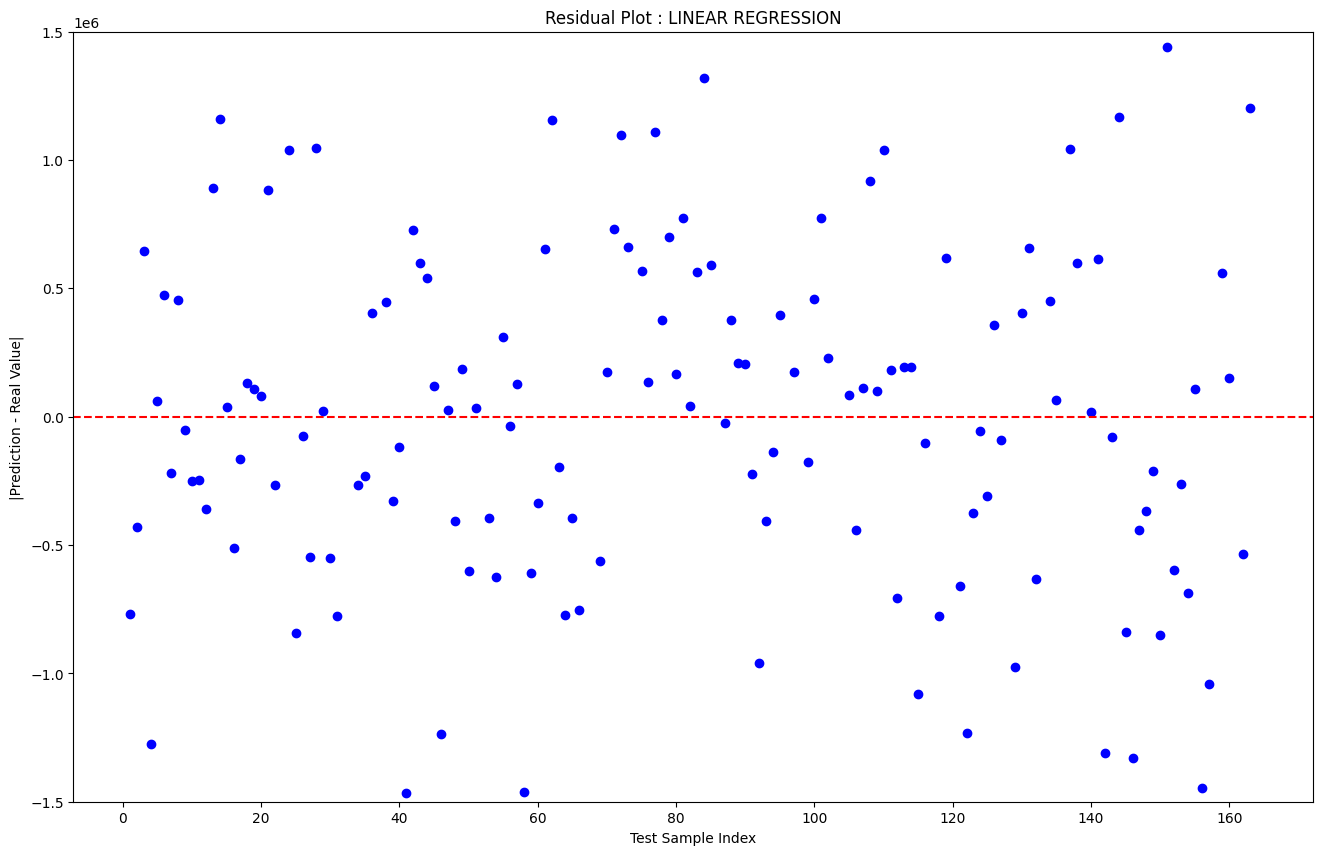

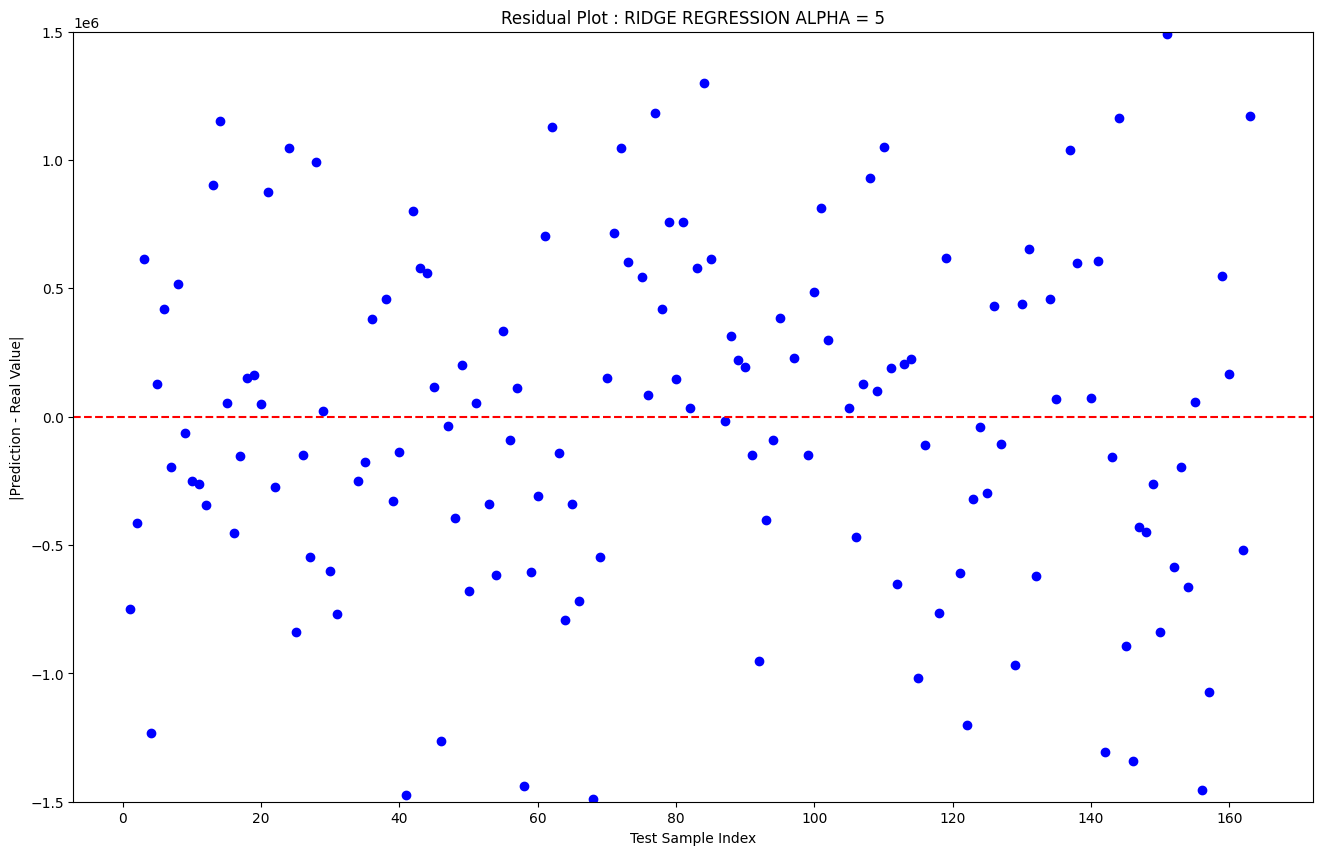

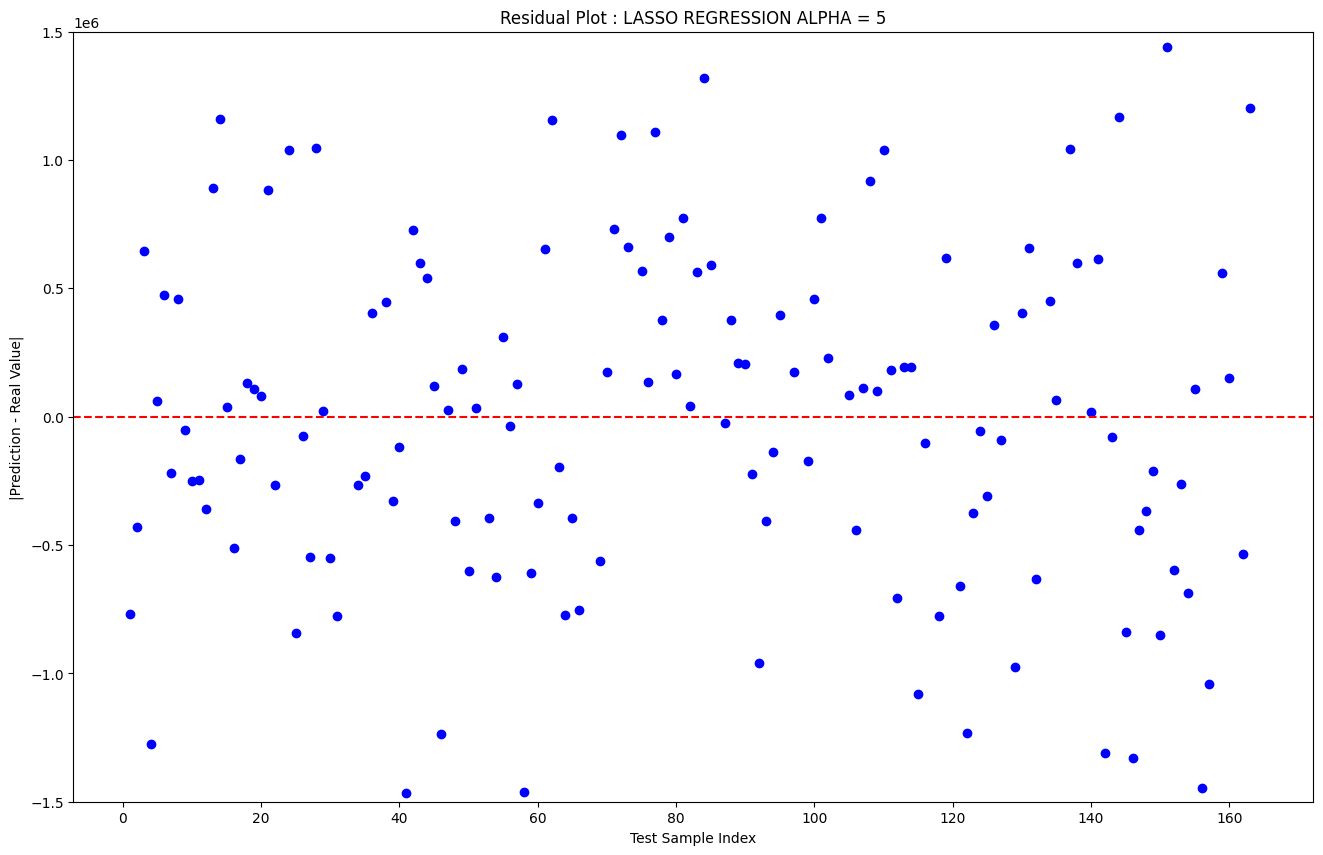

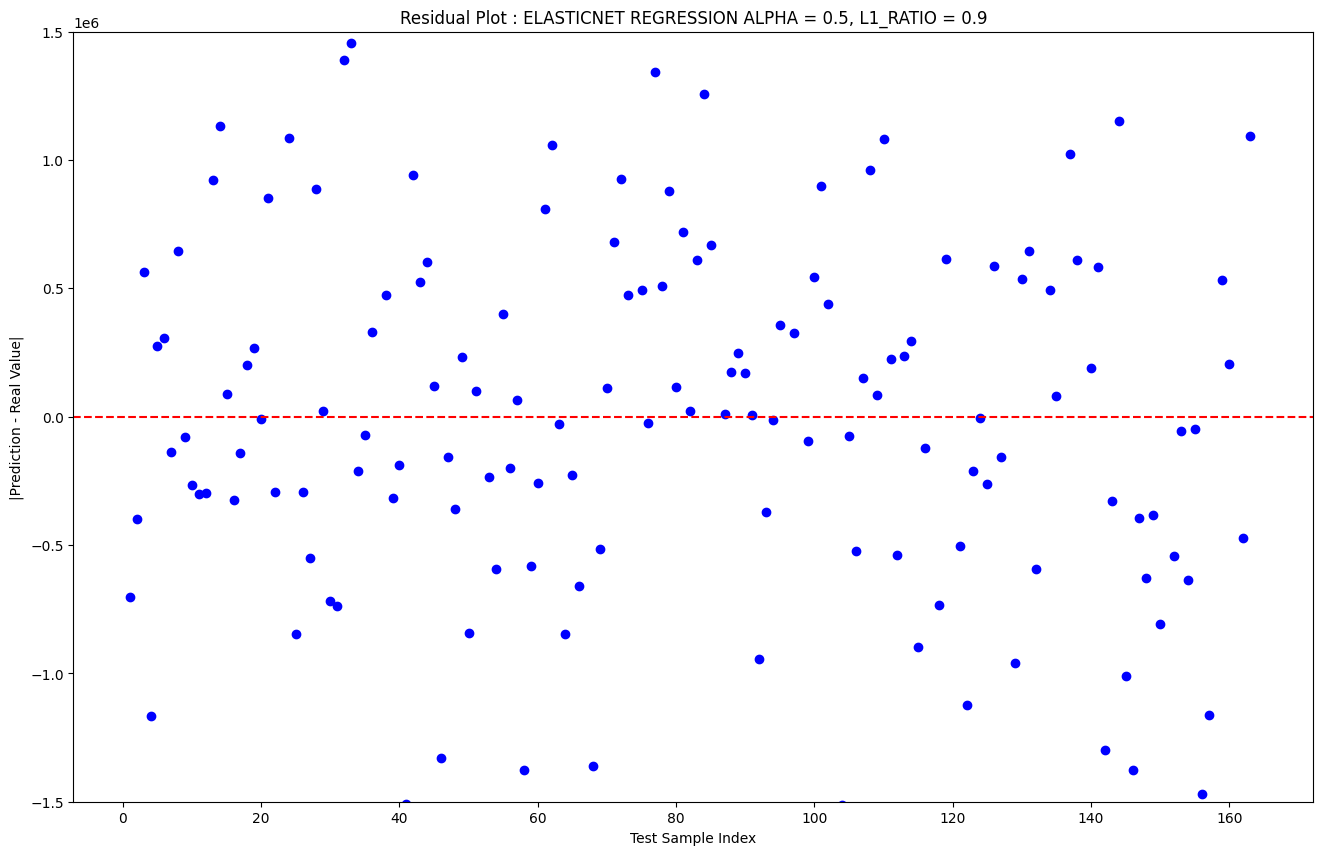

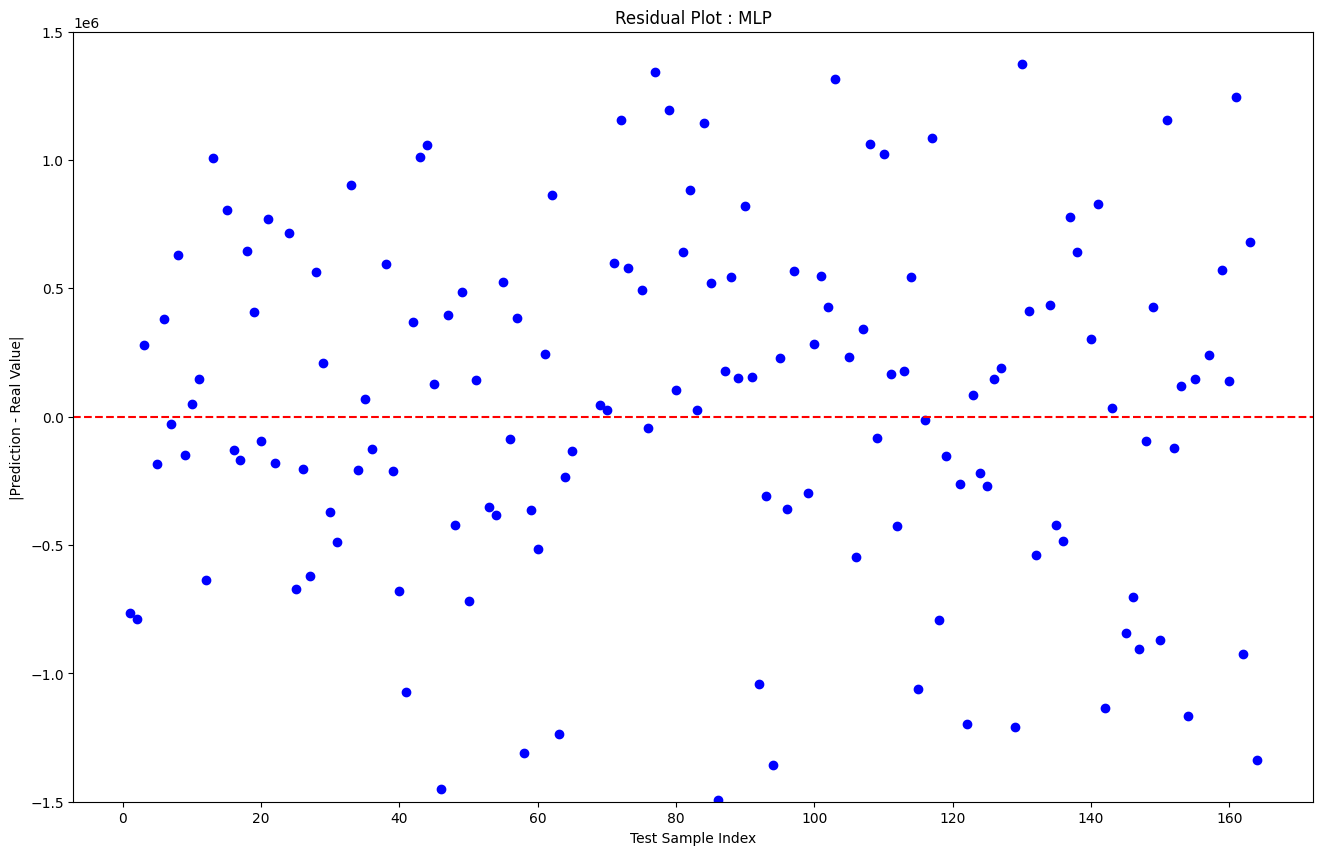

In [ ]:
residual_plot(predictions_lr, 1.5e6, title = models[0])
residual_plot(predictions_rr, 1.5e6, title = models[1])
residual_plot(predictions_lasso_r, 1.5e6, title = models[2])
residual_plot(predictions_en, 1.5e6, title = models[3])
residual_plot(predictions_mlp, 1.5e6, title = models[4])

Confrontiamo visivamente le principali metriche per ogni modello. Per avere un unico grafico comparativo, ed essendo $R^2$ e MSE su scale diverse, e' utile normalizzare le MSE dei vari modelli sul valore massimo. In questo modo, sia $R^2$ che MSE stanno nell'intervallo $[0,1]$:

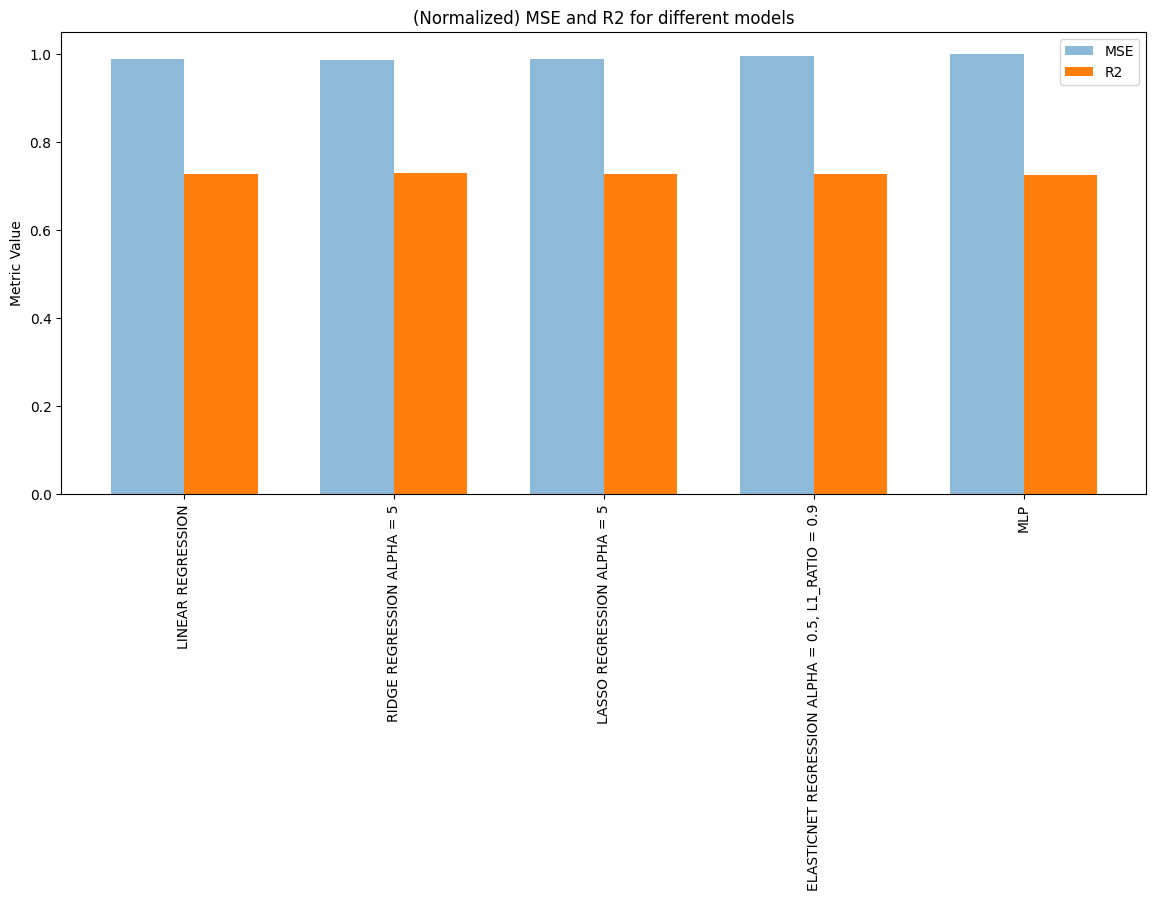

In [ ]:
mses = [metrics_lr[2], metrics_rr[2], metrics_lasso_r[2], metrics_en[2], metrics_mlp[2]]
r2s = [metrics_lr[3], metrics_rr[3], metrics_lasso_r[3], metrics_en[3], metrics_mlp[3]]

mses_norm = np.array(mses)/np.max(mses)

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize = (14, 6))
rects1 = ax.bar(x - width/2, mses_norm, width, label='MSE', alpha = 0.5)
rects2 = ax.bar(x + width/2, r2s, width, label='R2')

ax.set_ylabel('Metric Value')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_title('(Normalized) MSE and R2 for different models')
ax.legend()

plt.xticks(rotation = 90)
plt.show()

Come avevamo gia' visto dal confronto di tutte le metriche sopra, i valori di $R^2$ e MSE sono confrontabili fra i vari modelli. Overall, il modello migliore e' il ridge.

In conclusione, in questo notebook abbiamo affrontato un problema reale di regressione per stimare il prezzo di abitazioni. Avendo svolto tutte le analisi possibili, i risultati sono comunque deludenti. Questo non sorprende troppo, perche' il mercato immobiliare e' fortemente rumoroso ed afflitto da  soggettivita'. Inoltre il dataset e' relativamente piccolo, ed evidentemente le features fornite non sono sufficienti per comprendere i complicati patterns sottostanti al mercato.

In un contesto reale, sarebbe utile approfondire altri modelli di regressione per mercato immobiliare, per poter suggerire al reparto di analisi dati della casa immobiliare quali features potrebbero raccogliere per poter successivamente creare un modello piu' efficace.